## Dental Enumeration and Diagnosis on Panoramic X-rays ##

In [8]:
import os
import sys
import glob
import logging
import json
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2
import computervision
from computervision.dentex import Dentex
from computervision.imageproc import enclosing_box

# Print version info
print(f'Package version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Package version: v0.0.1
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [10]:
data_dir = os.path.join(os.environ.get('HOME'), 'data')
print(f'data_dir: {data_dir}')

# Directory to store the data
dataset_dir = os.path.join(data_dir, 'dentex')

# After extraction from the .tar.gz archive, the images should be on the local fs (see the first notebook)
xrays_dir = os.path.join(dataset_dir, 'quadrant_enumeration/xrays')

# Let's make sure that we have the expected number of images available
expected_images = 634
file_list = glob.glob(os.path.join(xrays_dir, '*.png'))
print('Make sure to run the first notebook which downloads the data.')
print(f'Found {len(file_list)} images in {xrays_dir}.')

# We want to be sure that the number of images is correct before we continue
assert expected_images == len(file_list), \
    f'WARNING: expected images ({expected_images}) != images on file system ({len(file_list)})'

data_dir: /app/data
Make sure to run the first notebook which downloads the data.
Found 634 images in /app/data/dentex/quadrant_enumeration/xrays.


## Load the annotations ##

In [11]:
json_file = os.path.join(dataset_dir, 'quadrant_enumeration/train_quadrant_enumeration.json')
parquet_file_name = f'{os.path.splitext(os.path.basename(json_file))[0]}.parquet'
parquet_file = os.path.join(data_dir, parquet_file_name)
try:
    df = pd.read_parquet(parquet_file)
except Exception as e:
    print(f'ERROR: Could not load file: \n {e}')
    print('Make sure to run the first notebook which downloads the data.')
display(df.head())

,iscrowd,image_id,bbox,segmentation,id,area,category_id_1,category_id_2,height,width,file_name,quadrant,pos,fdi,ada
0,0,1,"[1283.3333333333333, 459.25925925925924, 100.0...","[[1366, 459, 1383, 662, 1380, 716, 1295, 721, ...",1,22904,0,0,1316,2710,train_283.png,1,1,11,8
1,0,1,"[1200.0, 460.18518518518516, 90.74074074074065...","[[1290, 463, 1290, 619, 1276, 719, 1224, 725, ...",2,18597,0,1,1316,2710,train_283.png,1,2,12,7
2,0,1,"[1100.9259259259259, 451.85185185185185, 119.4...","[[1162, 451, 1212, 637, 1218, 663, 1220, 679, ...",3,24808,0,2,1316,2710,train_283.png,1,3,13,6
3,0,1,"[914.8148148148148, 466.66666666666663, 174.07...","[[965, 466, 1050, 562, 1088, 709, 1088, 760, 1...",4,28017,0,4,1316,2710,train_283.png,1,5,15,4
4,0,1,"[822.2222222222222, 484.25925925925924, 182.40...","[[915, 484, 981, 671, 997, 700, 1002, 721, 100...",5,35576,0,5,1316,2710,train_283.png,1,6,16,3


### Plot a panoramic radiograph with bounding boxes ###

In [71]:
print(im.shape)
print(10/im.shape[1])
print(70/im.shape[0])

(1316, 2780, 3)
0.0035971223021582736
0.05319148936170213


In [88]:
# Function to plot an image with bounding boxes
def plot_boxes(image, ax, box_list, label_list=None, color=None):
    offset_xy = (10, 80)
    # Take a ratio that looks good
    offset = (image.shape[1]*offset_xy[0]/2780,
              image.shape[0]*offset_xy[1]/1316)
    if color is None:
        # If no color is provided, color each box in a different color
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(box_list))))
    else:
        color_list = [color]*len(box_list)
    if label_list is None:
        label_list = list(np.arange(len(box_list)))
    # Create the figure
    ax.set(xticks=[], yticks=[])
    ax.imshow(image)
    # Loop over the bounding boxes
    for b, box in enumerate(box_list):
        rect = Rectangle(xy=(box[0], box[1]),
                         width=box[2],
                         height=box[3],
                         linewidth=1.5,
                         edgecolor=color_list[b],
                         facecolor='none',
                         alpha=0.7)
        ax.add_patch(rect)
        ax.text(x=box[0]+offset[0], y=box[1]+offset[1], s=label_list[b], color=color_list[b], fontsize=8)
    return ax

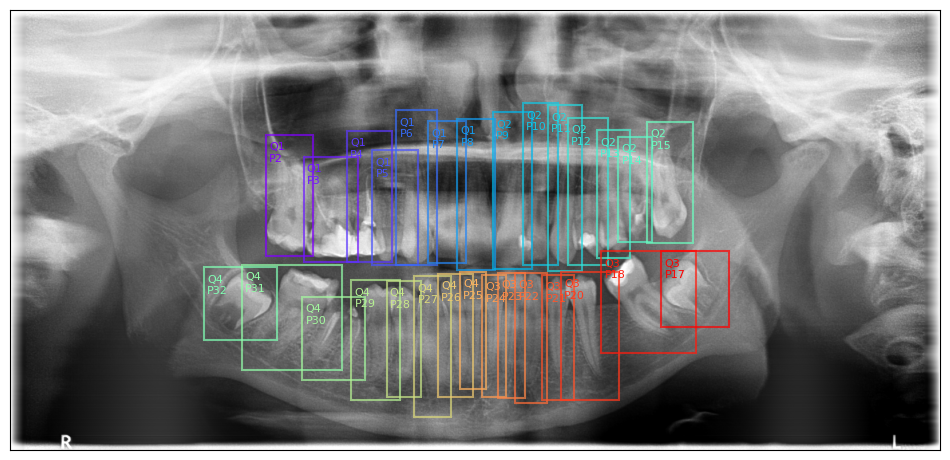

In [90]:
# Set a seed to make this more reproducible
seed = 114
rng = np.random.default_rng(seed=123)
file_name = rng.choice(a=df['file_name'].unique(), size=1)[0]
file = os.path.join(xrays_dir, file_name)
box_list = df.loc[df['file_name'] == file_name, 'bbox'].tolist()
quadrant_list = df.loc[df['file_name'] == file_name, 'quadrant'].tolist()
position_list = df.loc[df['file_name'] == file_name, 'ada'].tolist()
label_list = [f'Q{quadrant_list[b]}\nP{position_list[b]}' for b in range(len(box_list))]

# Load the image
im = plt.imread(file)

# Create the figure
fig, ax = plt.subplots(figsize=(12, 6))
ax = plot_boxes(image=im, ax=ax, box_list=box_list, label_list=label_list)

## Crop images by quadrants ##

In [91]:
display(df.head(2))
print(df.shape)

,iscrowd,image_id,bbox,segmentation,id,area,category_id_1,category_id_2,height,width,file_name,quadrant,pos,fdi,ada
0,0,1,"[1283.3333333333333, 459.25925925925924, 100.0...","[[1366, 459, 1383, 662, 1380, 716, 1295, 721, ...",1,22904,0,0,1316,2710,train_283.png,1,1,11,8
1,0,1,"[1200.0, 460.18518518518516, 90.74074074074065...","[[1290, 463, 1290, 619, 1276, 719, 1224, 725, ...",2,18597,0,1,1316,2710,train_283.png,1,2,12,7


(18095, 15)


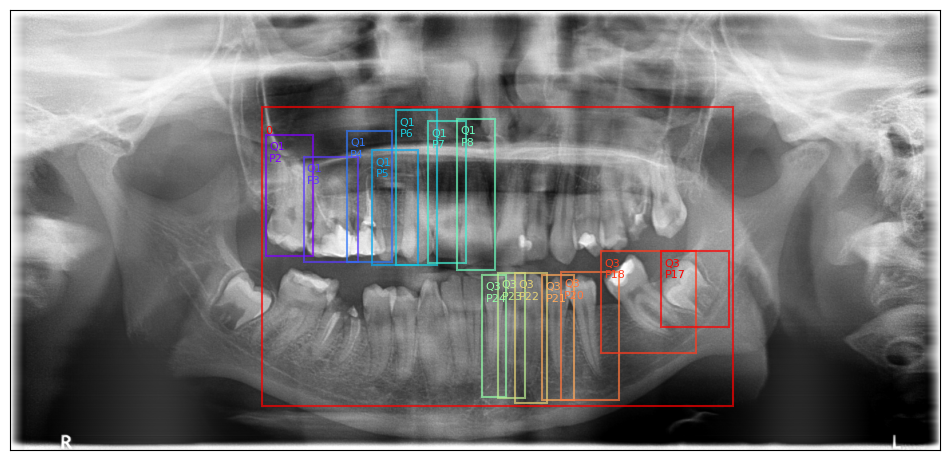

In [112]:
# Quadrants to include in the cropped image
quadrant_list = [1, 3]

# Annotations for the selected quadrants
dfq = df.loc[(df['file_name'] == file_name) & (df['quadrant'].isin(quadrant_list))]

# Get the bounding boxes and positions for these quadrants
box_list = [list(box) for box in dfq['bbox'].tolist()]
ada_list = dfq['ada'].tolist()
quad_list = dfq['quadrant'].tolist()
label_list = [f'Q{quad_list[b]}\nP{ada_list[b]}' for b in range(len(box_list))]

# Create a new bounding box that contains all of the selected bounding boxes
box = enclosing_box(bbox_list_xywh=box_list, offset=10)

# Create the figure
fig, ax = plt.subplots(figsize=(12, 6))
ax = plot_boxes(image=im, ax=ax, box_list=box_list, label_list=label_list, color=None)
ax = plot_boxes(image=im, ax=ax, box_list=[box], label_list=None, color='r')

# Save the figure 
file_name = '153846.png'
plt.savefig(os.path.join(data_dir, file_name), bbox_inches='tight')
plt.show()

In [111]:
pd.DataFrame(box_list)

,0,1,2,3
0,763.461538,373.076923,140.384615,361.538462
1,876.923077,438.461538,163.461538,315.384615
2,1005.769231,361.538462,134.615385,392.307692
3,1082.692308,419.230769,136.538462,344.230769
4,1153.846154,300.000000,121.153846,463.461538
5,1250.000000,332.692308,111.538462,423.076923
6,1336.538462,325.000000,111.538462,451.923077
7,1411.538462,792.307692,71.153846,363.461538
8,1459.615385,786.538462,80.769231,373.076923
9,1509.615385,786.538462,96.153846,388.461538


In [122]:
sequence_raw = [1, 2, 3, 4, 5, 6]
sequence_scaled = list(np.array(sequence_raw)/7)
sequence_scaled_100 = list(np.array(sequence_raw)/7 * 100)

In [123]:
print(sequence_raw)
print(sequence_scaled_100)

[1, 2, 3, 4, 5, 6]
[14.285714285714285, 28.57142857142857, 42.857142857142854, 57.14285714285714, 71.42857142857143, 85.71428571428571]
